In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

E:\anaconda3\envs\jcopdl2\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Data

In [2]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.dropna(inplace=True)
pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.day_of_week
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [3]:
df = df[(df.distance > 0) & (df.fare_amount)]

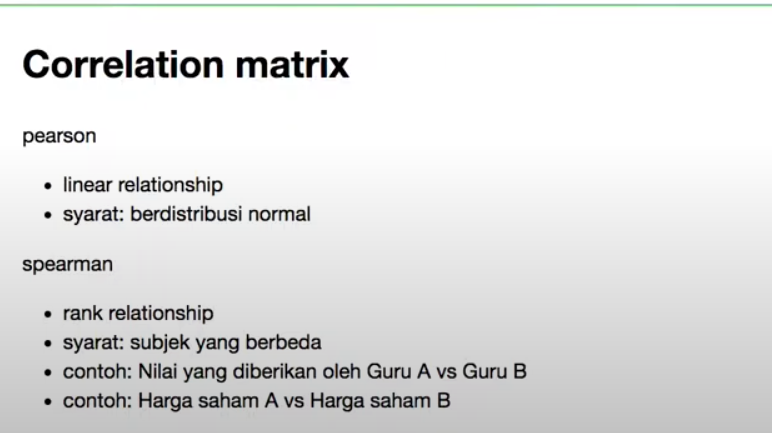

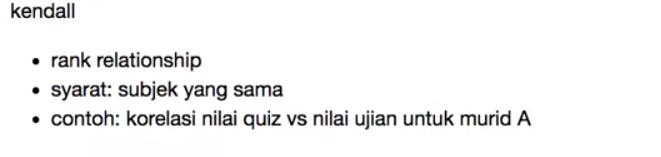

In [4]:
from jcopml.plot import plot_correlation_matrix

In [5]:
plot_correlation_matrix(df, 'fare_amount', numeric_col=['passenger_count', 'year', 'distance'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

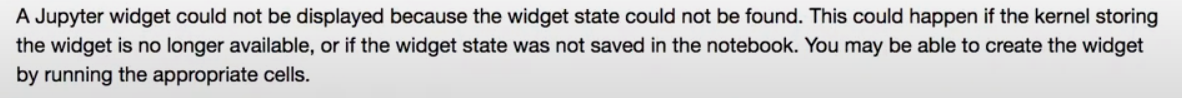

# Dataset Splitting

In [7]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14708, 6), (3677, 6), (14708,), (3677,))

# Training

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

3 base tidak ngaruh scaling

In [11]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["passenger_count", "year", "distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month", "day", "hour"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6024641082463879, 'algo__gamma': 7, 'algo__learning_rate': 0.04764963542138517, 'algo__max_depth': 3, 'algo__n_estimators': 118, 'algo__reg_alpha': 0.8013508750140631, 'algo__reg_lambda': 3.8765111709116367, 'algo__subsample': 0.7435432121325587}
0.7931247537399526 0.7773574160674886 0.8249358338670717


algo_reg_alpha = L1

algo_reg_lambda = L2

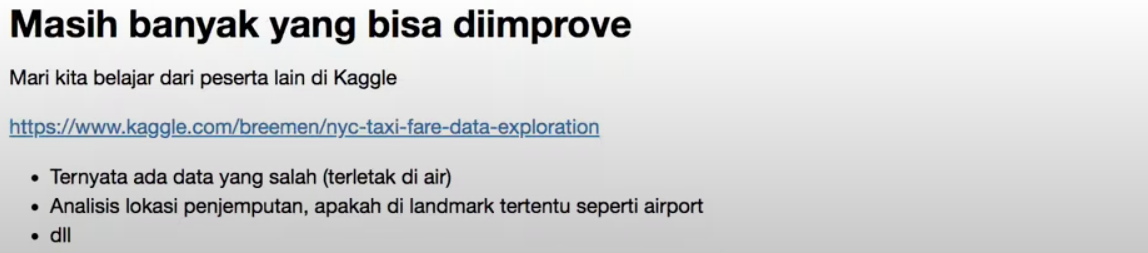